### The Oxford-IIIT Pet Dataset

Link to dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

### Important Libraries

In [54]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import matplotlib.patches as patches
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, Reshape
import cv2


### Lodaing Training data co-ordinates

In [55]:
data=pd.read_csv('data.csv')
data.head(2)

,Unnamed: 0,Path,height,width,x0,y0,x1,y1,_,__
0,0,./images/Abyssinian_1.jpg,400,600,173,72,265,158,abyssinian,0
1,1,./images/Abyssinian_10.jpg,500,375,72,105,288,291,abyssinian,0


### Loading Validation data co-ordinates

In [56]:
valid=pd.read_csv('valid.csv')
valid.head(2)

,Unnamed: 0,Path,height,width,x0,y0,x1,y1,_,__
0,0,./images/Abyssinian_118.jpg,500,333,1,34,257,303,abyssinian,0
1,1,./images/Abyssinian_124.jpg,500,333,88,94,207,195,abyssinian,0


### Path of the images

In [57]:
X_train=data["Path"]
X_valid=valid["Path"]

### Resizing of the train and validation co-ordinates

In [58]:
IMAGE_SIZE = 128
y_train=pd.DataFrame()
y_train["x0_re"]=data["x0"]*IMAGE_SIZE/data["width"]
y_train["y0_re"]=data["y0"]*IMAGE_SIZE/data["height"]
y_train["x1_re"]=(data["x1"]-data["x0"])*IMAGE_SIZE/data["width"]
y_train["y1_re"]=(data["y1"]-data["y0"])*IMAGE_SIZE/data["height"]

In [59]:
y_valid=pd.DataFrame()
y_valid["x0_re"]=valid["x0"]*IMAGE_SIZE/valid["width"]
y_valid["y0_re"]=valid["y0"]*IMAGE_SIZE/valid["height"]
y_valid["x1_re"]=(valid["x1"]-valid["x0"])*IMAGE_SIZE/valid["width"]
y_valid["y1_re"]=(valid["y1"]-valid["y0"])*IMAGE_SIZE/valid["height"]

### Visualization of image with bounding box

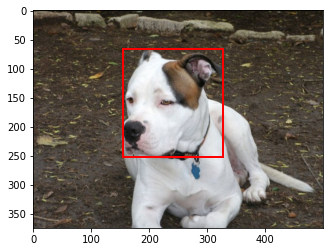

In [60]:
sample_image=data.loc[97]

x0=sample_image["x0"]
x1=sample_image["x1"]
y0=sample_image["y0"]
y1=sample_image["y1"]

fig,ax = plt.subplots(1)
ax.imshow(imread(X_train[97]))
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

### Pre-processing of the train and validation data

In [63]:
X_tran=[]
for i, j in enumerate(X_train):
    img=image.load_img(j,target_size=(128,128))
    img_ar=image.img_to_array(img)
    X_tran.append(tf.keras.applications.mobilenet.preprocess_input(img_ar))
X_train=np.array(X_tran)

X_val=[]
for i, j in enumerate(X_valid):
    img=image.load_img(j,target_size=(128,128))
    img_ar=image.img_to_array(img)
    X_val.append(tf.keras.applications.mobilenet.preprocess_input(img_ar))
X_valid=np.array(X_val)

### Model

In [64]:
def IOU(a, b, epsilon=1e-5):

    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)

    width = (x2 - x1)
    height = (y2 - y1)

    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    iou = area_overlap / (area_combined + epsilon)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(IOU, [y_true, y_pred], Tout=tf.float32)
    return iou

In [65]:
base_model=MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    

model=Sequential([base_model])
model.add(Conv2D(4,kernel_size=4,name='coords'))
model.add(Reshape((4,)))

model.compile(loss="mean_squared_error", optimizer="adam",metrics=[IoU]) # Regression loss is MSE

### Training the model

In [67]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01)
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
94/94 [==============================] - 34s 365ms/step - loss: 55.5079 - IoU: 0.3075 - val_loss: 90.3940 - val_IoU: 0.2682
Epoch 2/10
94/94 [==============================] - 37s 391ms/step - loss: 40.8056 - IoU: 0.3313 - val_loss: 90.5167 - val_IoU: 0.2523
Epoch 3/10
94/94 [==============================] - 35s 371ms/step - loss: 31.2386 - IoU: 0.3504 - val_loss: 89.7212 - val_IoU: 0.2616
Epoch 4/10
94/94 [==============================] - 35s 376ms/step - loss: 23.8553 - IoU: 0.3686 - val_loss: 88.7862 - val_IoU: 0.2703
Epoch 5/10
94/94 [==============================] - 38s 401ms/step - loss: 18.4828 - IoU: 0.3860 - val_loss: 90.5546 - val_IoU: 0.2563
Epoch 6/10
94/94 [==============================] - 35s 374ms/step - loss: 14.4694 - IoU: 0.4012 - val_loss: 90.2640 - val_IoU: 0.2633


In [11]:
model.evaluate(X_valid, y_valid)

22/22 [==============================] - 7s 329ms/step - loss: 99.6828


99.68276977539062

### Testing

In [70]:
filename = 'C:/Users/Kishore1/Desktop/dog.jpg'
unscaled = plt.imread(filename)

In [71]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) 
feat_scaled = tf.keras.applications.mobilenet.preprocess_input(np.array(image, dtype=np.float32))

In [72]:
region = model.predict(x=np.array([feat_scaled]))[0]
region

array([19.187365, 16.822971, 73.21892 , 34.18312 ], dtype=float32)

In [73]:
x0 = int(region[0] * image_width / IMAGE_SIZE) 
y0 = int(region[1] * image_height / IMAGE_SIZE)
x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

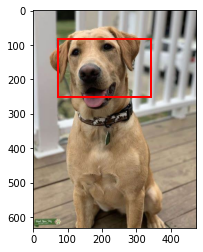

In [74]:
fig,ax = plt.subplots(1)
ax.imshow(unscaled)
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()